In [1]:
import pandas as pd
#from bunkadata.graphdb.extract_entity import get_wikidata_id
from bunkadata.scraping.wikidata.wikidata import get_feature_func, get_wikidata_id
from tqdm.notebook import tqdm
tqdm.pandas()

from bunkatech.nested_topic_modeling import NestedTopicModeling

In [25]:
data = pd.read_excel('labeling/SHAI-LABELS-ROUND-1.xlsx')
data = pd.read_csv('/Volumes/OutFriend/shaping_ai/SHAI-CORPUS-MODEL-ALL-R2.csv', sep = ';')
data['bindex'] = data.index

In [26]:
bunka = NestedTopicModeling()
model = bunka.fit(
    data,
    text_var="content",
    index_var="bindex",
    sample_size=10000,
    sample_terms=10000,
    embeddings_model="tfidf",
    ngrams=(2,2),
    ents=True,
    language="fr",
    db_path=".",
)

Embeddings..
Reducing the vectors..
UMAP(angular_rp_forest=True, metric='cosine', n_components=5, n_neighbors=10, verbose=True)
Wed Mar  9 15:03:55 2022 Construct fuzzy simplicial set
Wed Mar  9 15:03:55 2022 Finding Nearest Neighbors
Wed Mar  9 15:03:55 2022 Building RP forest with 10 trees
Wed Mar  9 15:04:03 2022 metric NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	 7  /  13
	 8  /  13
	Stopping threshold met -- exiting after 8 iterations
Wed Mar  9 15:06:33 2022 Finished Nearest Neighbor Search
Wed Mar  9 15:06:34 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Mar  9 15:06:41 2022 Finished embedding


Extract Terms:  40%|█████████▋              | 4038/9993 [05:40<07:10, 13.82it/s]

KeyboardInterrupt: 

In [4]:
#fig = model.visualize_embeddings(nested_level = 1 , width = 1000, height = 600)
#fig.show()

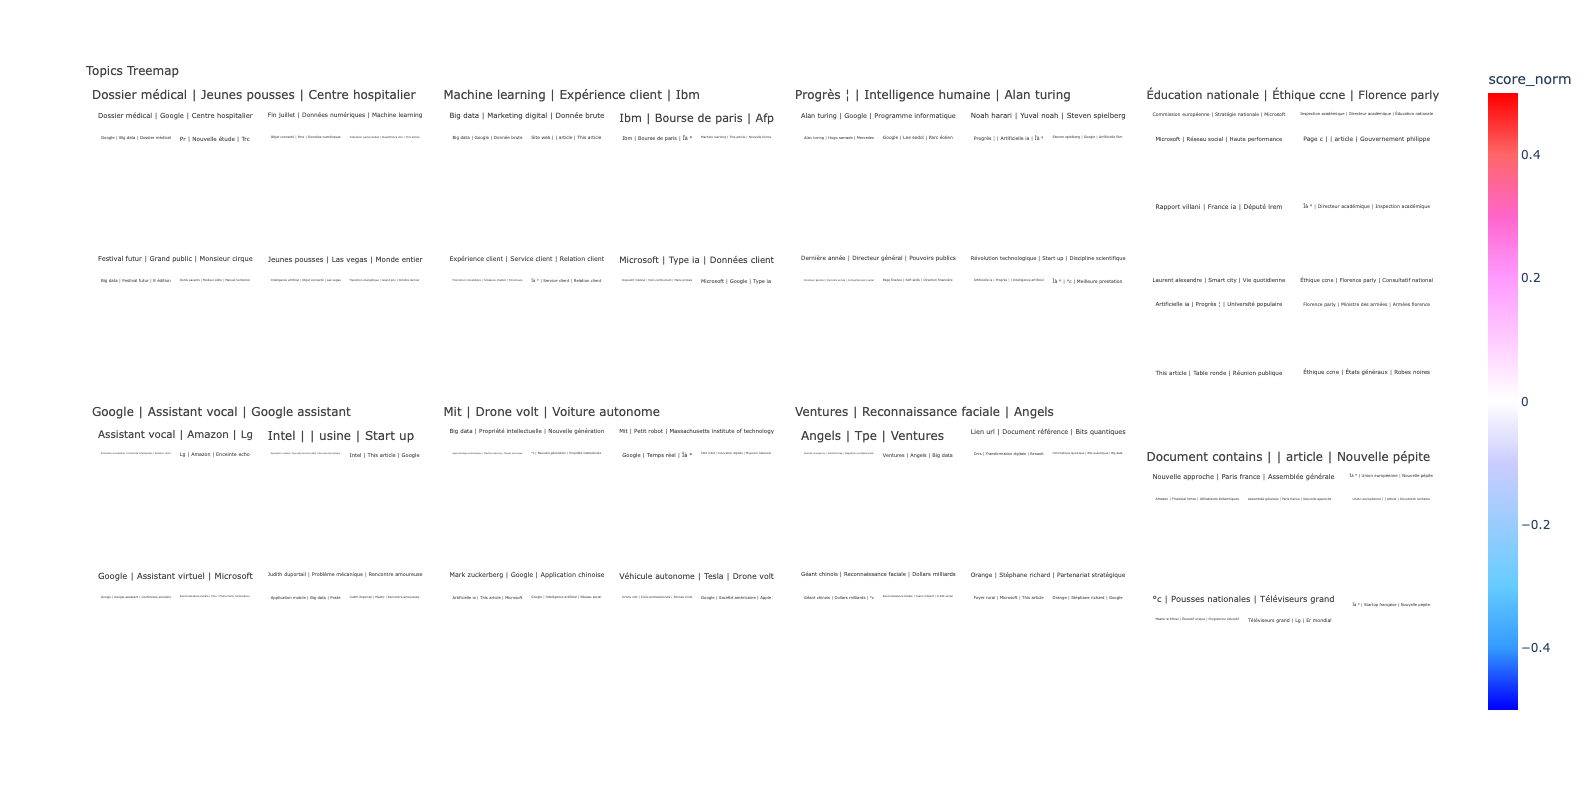

In [18]:
#topic_documents
#equal_size
# Umap fit
# soit le résultat est imposé, soit c'est un search
# active learning

treemap = bunka.make_nested_maps(
    size_rule="equal_size", map_type="treemap", width = 800, height = 800, query = "sex"
)

treemap.show()

In [6]:
terms = model.terms
terms['wikidata_id'] = terms['main form'].progress_apply(lambda x : get_wikidata_id(x, language = 'fr'))

  0%|          | 0/4000 [00:00<?, ?it/s]

In [7]:
new_terms = terms[terms['wikidata_id'].notna()]
# instance of
new_terms['instance_of'] = new_terms['wikidata_id'].progress_apply(lambda x: get_feature_func(x, feature_id='P31'))

  0%|          | 0/574 [00:00<?, ?it/s]

In [11]:
new_terms.to_csv('results/wikidata_extract.csv')

In [15]:
import bamboolib

In [16]:
fin = new_terms[new_terms['instance_of'].notna()]
fin

,lemma,main form,text,ent,count_terms,chi2,wikidata_id,instance_of
2,googl,Google,google,ORG,50,349.969765,Q95,public company
3,google,Google,google,ORG,33,188.442953,Q95,public company
4,site web,Site web,site web | sites web,NaN,31,137.733585,Q35127,web server
5,microsoft,Microsoft,microsoft,ORG,28,245.238783,Q2283,public company
6,temps réel,Temps réel,temps réel,NaN,24,140.696369,Q347066,quality
...,...,...,...,...,...,...,...,...
3767,évolution humain,Évolution humaine,évolution humaine,NaN,1,7.215608,Q83944,field of work
3886,ville américain,Villes américaines,villes américaines,NaN,1,7.215608,Q3475546,Wikimedia list article
3905,vieux continent,Vieux continent,vieux continent,NaN,1,7.215608,Q46,continent
3957,vendredi soir,Vendredi soir,vendredi soir,NaN,1,7.215608,Q3555451,film


#### Get the networks

In [32]:
df_indexed = model.indexed_terms[['docs', 'lemma']]
df_indexed_wikidata = pd.merge(df_indexed, fin, on = 'lemma')
df_indexed_wikidata['enrich_form'] = df_indexed_wikidata['main form'] + ' (' +  df_indexed_wikidata['instance_of'] + ')'

In [34]:
df_indexed_wikidata = df_indexed_wikidata[['docs', 'instance_of', 'enrich_form']]
df_indexed_wikidata

,docs,instance_of,enrich_form
0,volpy récolte m€ de plus auprès de business ...,instrumental band,Ventures (instrumental band)
1,risque uipath engrange m$ pour sa série b ...,instrumental band,Ventures (instrumental band)
2,l'assureur de nouvelle génération luko récolt...,instrumental band,Ventures (instrumental band)
3,gridc réalise une levée de fonds d' m$ ...,instrumental band,Ventures (instrumental band)
4,gleamer lève millions d'euros pour diffuser ...,instrumental band,Ventures (instrumental band)
...,...,...,...
1142,bassin alésien feria d'alès sorties ...,music genre,Swing jazz (music genre)
1143,en le monde n'attendra pas les trains frança...,intergovernmental organization,Otan (intergovernmental organization)
1144,cybersécurité un risque pour tous à la porté...,internet genre,Monde virtuel (internet genre)
1145,comment joue l'intelligence artificielle ...,game theory term,Meilleure réponse (game theory term)


In [35]:
from bunkatech.networks.networks import network_analysis

In [47]:
res = network_analysis(df_indexed_wikidata, 
                      variables = ['enrich_form'],
                      key = 'docs',
                      method = 'node2vec',
                      height_att = 1000, 
                      width_att = 1000,
                      n_neighbours = 7,
                      global_filter = 0.3,
                      top_nodes = 400)

Computing transition probabilities:   0%|          | 0/219 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 2/2 [00:00<00:00,  8.78it/s]2022-03-07 13:06:30,342 - INFO : collecting all words and their counts
2022-03-07 13:06:30,344 - INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-03-07 13:06:30,366 - INFO : collected 219 word types from a corpus of 175200 raw words and 2190 sentences
2022-03-07 13:06:30,367 - INFO : Creating a fresh vocabulary
2022-03-07 13:06:30,369 - INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 219 unique words (100.0%% of original 219, drops 0)', 'datetime': '2022-03-07T13:06:30.369340', 'gensim': '4.1.2', 'python': '3.8.2 (v3.8.2:7b3ab5921f, Feb 24 2020, 17:52:18) \n[Clang 6.0 (clang-600.0.57)]', 'platform': 'macOS-10.15.5-x86_64-i386-64bit', 'event': 'prepare_vocab'}
2022-03-07 13:06:30,370 - INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 175200 word corpus (100.0%% of original 175200, drops 0)', 'datetime': '2022-03-07T13:06:30.370485', 'gensim': '

In [48]:
import plotly
plotly.offline.plot(res, filename = 'results/enrich_data_lead_paragraph.html', auto_open=True)

'results/enrich_data_lead_paragrapg.html'

In [49]:
res = network_analysis(df_indexed_wikidata, 
                      variables = ['instance_of'],
                      key = 'docs',
                      method = 'node2vec',
                      height_att = 1000, 
                      width_att = 1000,
                      n_neighbours = 7,
                      global_filter = 0.3,
                      top_nodes = 400)

plotly.offline.plot(res, filename = 'results/instance_of_data_lead_paragraph.html', auto_open=True)

Computing transition probabilities:   0%|          | 0/160 [00:00<?, ?it/s]


Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00, 21.61it/s]2022-03-07 13:07:30,168 - INFO : collecting all words and their counts
2022-03-07 13:07:30,169 - INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-03-07 13:07:30,184 - INFO : collected 160 word types from a corpus of 128000 raw words and 1600 sentences
2022-03-07 13:07:30,185 - INFO : Creating a fresh vocabulary
2022-03-07 13:07:30,186 - INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 160 unique words (100.0%% of original 160, drops 0)', 'datetime': '2022-03-07T13:07:30.186431', 'gensim': '4.1.2', 'python': '3.8.2 (v3.8.2:7b3ab5921f, Feb 24 2020, 17:52:18) \n[Clang 6.0 (clang-600.0.57)]', 'platform': 'macOS-10.15.5-x86_64-i386-64bit', 'event': 'prepare_vocab'}
2022-03-07 13:07:30,187 - INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 128000 word corpus (100.0%% of original 128000, drops 0)', 'datetime': '2022-03-07T13:07:30.187024', 'gensim': 

'results/instance_of_data_lead_paragraph.html'

In [23]:
# Subclass of
#new_terms['sublass_of'] = new_terms['wikidata_id'].progress_apply(lambda x: get_feature_func(x, feature_id='P279'))

In [24]:
#import bamboolib
#new_terms

In [61]:
new_terms.to_csv('results_terms_wikidata.csv')
test = new_terms[new_terms['instance_of'].notna()]
test = test[test['instance_of'] != 'Wikimedia disambiguation page']
test = test[test['instance_of'] != 'Wikimedia human name disambiguation page']
test

,Unnamed: 0,stem,main form,forms,ent,frequency,chi2,extract_type,wikidata_id,sublass_of,instance_of
0,0,google,GOOGLE,Google|&|google|&|GOOGLE,ORG,708,4806.389143,entities,Q95,None,public company
1,1,microsoft,MICROSOFT,Microsoft|&|MICROSOFT|&|microsoft,ORG,318,2044.619320,entities,Q2283,None,public company
3,3,ibm,IBM,IBM,ORG,264,2433.475947,entities,Q37156,None,computer hardware
6,6,elon musk,Elon Musk,Elon Musk,PER|&|ORG,163,1229.772746,entities,Q317521,None,human
8,8,mit,MIT,MIT,ORG,135,842.667106,entities,Q49108,None,university
...,...,...,...,...,...,...,...,...,...,...,...
8735,3735,marc andreessen,Marc Andreessen,Marc Andreessen,NP,5,39.539776,bigrams_nouns,Q62882,None,human
8985,3985,de leamour,de l'amour,de l'amour,NP,5,38.628169,bigrams_nouns,Q4728510,None,film
9094,4094,sciences et avenir,Sciences et Avenir,Sciences et Avenir,NP,4,31.631821,bigrams_nouns,Q546262,None,periodical
9195,4195,roger penrose,Roger Penrose,Roger Penrose,NP,4,32.524395,bigrams_nouns,Q193803,None,human


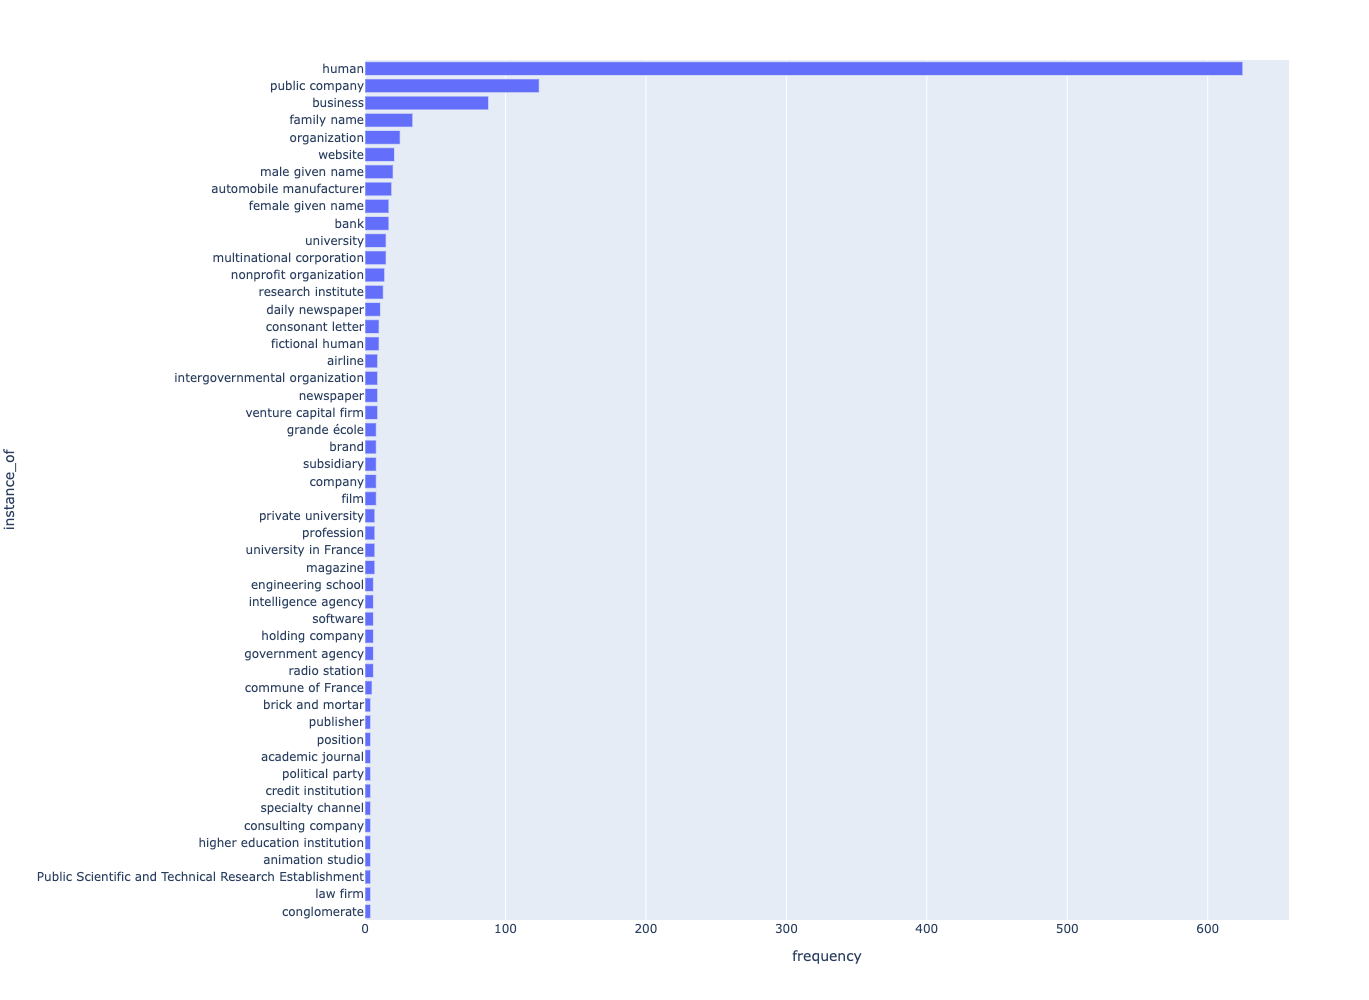

In [59]:



test = test.groupby('instance_of')['frequency'].count().reset_index().sort_values('frequency', ascending=True)

import plotly.express as px
fig = px.bar(test.tail(50), x='frequency', y='instance_of', height = 1000)
fig